In [2072]:
import json
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import re
import seaborn as sns

from classifier import *
from heapq import nlargest
from issues import get_num_code_lines
from nltk.stem import PorterStemmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Pre-Processing

In [2073]:
with open('../data/flutter/flutter_issues_labeled.json') as json_data:
    issues = json.load(json_data)

In [2074]:
print("Number of issues: " + str(len(issues)))
labeled_issues = [issue for issue in issues if len(issue['completed_by']) > 0]
print("Number of labeled issues: " + str(len(labeled_issues)))

Number of issues: 7170
Number of labeled issues: 2504


In [2075]:
# create a data frame from the list of issues
df_list = []
for issue in labeled_issues[25:]:
        df_dict = {}
        df_dict['comments'] = issue['comments']
        if (not issue['body']):
            issue['body'] = ""
        df_dict['title'] = issue['title']
        df_dict['body'] = issue['body']
        df_dict['closed_date'] = pd.to_datetime(issue['closed_at'])
        df_dict['created_date'] = pd.to_datetime(issue['created_at'])
        df_dict['completed_by'] = issue['completed_by']
        #TODO: figure out how to one-hot-encode labels!!!!!!!!
        df_dict['labels'] = [label['name'] for label in issue['labels']]
        df_list.append(df_dict)
df = pd.DataFrame(df_list).sort_values('closed_date')
df.head(2)

,body,closed_date,comments,completed_by,created_date,labels,title
1,When I try to `flutter start` any of the examp...,2015-11-09 20:13:32,3,"[abarth, DanTup]",2015-11-08 20:33:37,"[easy fix, tool]",`flutter start` doesn't give good error messag...
6,"<a href=""https://github.com/Hixie""><img src=""h...",2015-11-09 20:18:24,1,[yjbanov],2015-11-09 20:16:52,"[framework, severe: new feature]",Swipe to change between Tabs


In [2076]:
# count number of issues with multiple completers
counts = {}
for index, row in df.iterrows():
    count = len(row['completed_by'])
    counts[count] = counts.get(count, 0) + 1
print(counts)
#TODO: confirm that filtering "noise" is best strategy here
print("Number of total issues: " + str(len(df)))
df = df[df.apply(lambda x: len(x['completed_by']) == 1, axis=1)].reset_index(drop=True)
df['completed_by'] = df['completed_by'].apply(lambda  x : x[0])
print("Number of issues with single solver: " + str(len(df)))

{2: 197, 1: 2268, 3: 14}
Number of total issues: 2479
Number of issues with single solver: 2268


In [2077]:
# one hot encode the label column
mlb = MultiLabelBinarizer()
df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('labels')),
                          columns=mlb.classes_,
                          index=df.index))
df.head(2)

,body,closed_date,comments,completed_by,created_date,title,a: accessibility,a: animation,a: china,a: fidelity,...,team: gallery,tool,waiting for PR to land (fixed),waiting for customer response,⌘‬ platform-mac,⌺‬ platform-ios,▣ platform-android,○ platform-fuchsia,⚠ TODAY,❖ platform-windows
0,"<a href=""https://github.com/Hixie""><img src=""h...",2015-11-09 20:18:24,1,yjbanov,2015-11-09 20:16:52,Swipe to change between Tabs,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,flutter start --debug\nsevere: To copy files t...,2015-11-09 21:43:40,1,abarth,2015-11-09 20:50:45,Exception running source build of engine on Mac,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [2078]:
def preprocess(text):
    stemmer = PorterStemmer()
    # remove punctuation and non-alpha numeric characters
    split1 = ' '.join([word for word in re.split('\W+', text) if word.isalpha()])
    # split camel case words apart (necessary for embedded code) and apply stemmer to all words
    split2 = ' '.join([stemmer.stem(word) for word in re.sub('(?!^)([A-Z][a-z]+)', r' \1', split1).split()])
    return split2

In [2079]:
# use tf-idf w/ stemming, stop-word removal, and non-alphabetic word removal to generate features
df['body'] = df['body'].apply(preprocess)
vectorizer_body = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS)
vectorizer_body.fit(df['body'])
vector_body = vectorizer_body.transform(df['body'])
# summarize encoded vector
print(vector_body.shape)
df['title'] = df['title'].apply(preprocess)
vectorizer_title = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS)
vectorizer_title.fit(df['title'])
vector_title = vectorizer_title.transform(df['title'])
# summarize encoded vector
print(vector_title.shape)

(2268, 4960)
(2268, 1804)


In [2080]:
title_df = pd.DataFrame(vector_title.todense())
body_df = pd.DataFrame(vector_body.todense())
df = pd.concat([df, title_df, body_df], axis=1)
df.head(2)

,body,closed_date,comments,completed_by,created_date,title,a: accessibility,a: animation,a: china,a: fidelity,...,4950,4951,4952,4953,4954,4955,4956,4957,4958,4959
0,a href http github com hixi img src http avata...,2015-11-09 20:18:24,1,yjbanov,2015-11-09 20:16:52,swipe to chang between tab,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,flutter start debug sever To copi file to io d...,2015-11-09 21:43:40,1,abarth,2015-11-09 20:50:45,except run sourc build of engin on mac,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2081]:
# get list of devs who solve an issue in last three months (from end of train set)
active_devs = set()
dev_counts = {}
filter_date = df.iloc[2000]['closed_date'] - pd.to_timedelta(90, unit='d')
for _, row in df.iterrows():
    if (row['closed_date'] > filter_date):
        dev_counts[row['completed_by']] = dev_counts.get(row['completed_by'], 0) + 1
print(dev_counts)
for dev in dev_counts:
    if dev_counts[dev] >= 3:
        active_devs.add(dev)
print(active_devs)
# remove all issues not solved by an active dev
df = df[df['completed_by'].isin(active_devs)].reset_index(drop=True)
print(len(df))

{'jason-simmons': 21, 'aam': 27, 'yjbanov': 16, 'cbracken': 34, 'Hixie': 33, 'gspencergoog': 10, 'xster': 50, 'goderbauer': 41, 'a-siva': 1, 'chinmaygarde': 1, 'mravn-google': 21, 'HansMuller': 35, 'abarth': 1, 'tvolkert': 17, 'amirh': 4, 'Skylled': 1, 'leobispo': 1, 'sigurdm': 1, 'mehmetf': 1, 'fredriks': 1, 'jakobr-google': 1, 'crelier': 1, 'alibitek': 1, 'mit-mit': 3, 'jcollins-g': 11, 'dnfield': 2, 'DanTup': 5, 'mraleph': 4, 'rmacnak-google': 1, 'DaveShuckerow': 2, 'szakarias': 3, 'xqwzts': 5, 'jonahwilliams': 27, 'danrubel': 1, 'konifar': 2, 'sroddy': 1, 'matanlurey': 1, 'srawlins': 1, 'sbaranov': 1, 'OhadRau': 1, 'scheglov': 2, 'filleduchaos': 1, 'blasten': 2, 'mattsarett': 1, 'devoncarew': 6, 'liyuqian': 1, 'slightfoot': 2, 'ng1905': 1, 'fmatosqg': 2, 'paulcbetts': 1}
{'devoncarew', 'DanTup', 'goderbauer', 'mravn-google', 'HansMuller', 'Hixie', 'jason-simmons', 'cbracken', 'jcollins-g', 'tvolkert', 'mit-mit', 'aam', 'xster', 'amirh', 'mraleph', 'xqwzts', 'gspencergoog', 'yjbanov

# Machine Learning

In [2082]:
train_df = df[:1100]
test_df = df[1100:]
X_train = train_df.drop(['body', 'closed_date', 'completed_by', 'created_date', 'title', 'comments'], axis=1)
y_train = train_df['completed_by']
X_test = test_df.drop(['body', 'closed_date', 'completed_by', 'created_date', 'title', 'comments'], axis=1)
y_test = test_df['completed_by']
print(len(X_train))
print(len(X_test))

1100
337


In [2083]:
def is_correct_top_k(pred_prob, k, actual, labels):
    indices = [i for i in range(len(pred_prob))]
    top_indices = nlargest(k, indices, key=lambda i: pred_prob[i])
    top_choices = set([labels[i] for i in top_indices])
    return actual in top_choices

In [2084]:
classifier = MLPClassifier(hidden_layer_sizes=(25,25))
classifier.fit(X_train,y_train)
classes = classifier.classes_
print("Top 1 Accuracy: " + str(classifier.score(X_test, y_test)))
pred_probs = classifier.predict_proba(X_test)
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 2, y_test[1100 + idx], classes):
        correct += 1
print ("Top 2 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 3, y_test[1100 + idx], classes):
        correct += 1
print ("Top 3 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 4, y_test[1100 + idx], classes):
        correct += 1
print ("Top 4 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 5, y_test[1100 + idx], classes):
        correct += 1
print ("Top 5 Accuracy: " + str((correct/len(y_test))))

Top 1 Accuracy: 0.3056379821958457
Top 2 Accuracy: 0.4065281899109792
Top 3 Accuracy: 0.4807121661721068
Top 4 Accuracy: 0.5578635014836796
Top 5 Accuracy: 0.6023738872403561


In [2085]:
classifier = GaussianNB()
classifier.fit(X_train,y_train)
classes = classifier.classes_
print("Top 1 Accuracy: " + str(classifier.score(X_test, y_test)))
pred_probs = classifier.predict_proba(X_test)
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 2, y_test[1100 + idx], classes):
        correct += 1
print ("Top 2 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 3, y_test[1100 + idx], classes):
        correct += 1
print ("Top 3 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 4, y_test[1100 + idx], classes):
        correct += 1
print ("Top 4 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 5, y_test[1100 + idx], classes):
        correct += 1
print ("Top 5 Accuracy: " + str((correct/len(y_test))))

Top 1 Accuracy: 0.2166172106824926
Top 2 Accuracy: 0.2314540059347181
Top 3 Accuracy: 0.2818991097922849
Top 4 Accuracy: 0.3115727002967359
Top 5 Accuracy: 0.3649851632047478


In [2086]:
classifier = BernoulliNB()
classifier.fit(X_train,y_train)
classes = classifier.classes_
print("Top 1 Accuracy: " + str(classifier.score(X_test, y_test)))
pred_probs = classifier.predict_proba(X_test)
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 2, y_test[1100 + idx], classes):
        correct += 1
print ("Top 2 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 3, y_test[1100 + idx], classes):
        correct += 1
print ("Top 3 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 4, y_test[1100 + idx], classes):
        correct += 1
print ("Top 4 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 5, y_test[1100 + idx], classes):
        correct += 1
print ("Top 5 Accuracy: " + str((correct/len(y_test))))

Top 1 Accuracy: 0.14540059347181009
Top 2 Accuracy: 0.22551928783382788
Top 3 Accuracy: 0.26409495548961426
Top 4 Accuracy: 0.34718100890207715
Top 5 Accuracy: 0.4421364985163205


In [2087]:
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train, y_train)
classes = classifier.classes_
print("Top 1 Accuracy: " + str(classifier.score(X_test, y_test)))
pred_probs = classifier.predict_proba(X_test)
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 2, y_test[1100 + idx], classes):
        correct += 1
print ("Top 2 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 3, y_test[1100 + idx], classes):
        correct += 1
print ("Top 3 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 4, y_test[1100 + idx], classes):
        correct += 1
print ("Top 4 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 5, y_test[1100 + idx], classes):
        correct += 1
print ("Top 5 Accuracy: " + str((correct/len(y_test))))

Top 1 Accuracy: 0.1543026706231454
Top 2 Accuracy: 0.26706231454005935
Top 3 Accuracy: 0.31750741839762614
Top 4 Accuracy: 0.34124629080118696
Top 5 Accuracy: 0.3916913946587537


In [2088]:
classifier = RandomForestClassifier(n_estimators=1000)
classifier.fit(X_train, y_train)
classes = classifier.classes_
print("Top 1 Accuracy: " + str(classifier.score(X_test, y_test)))
pred_probs = classifier.predict_proba(X_test)
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 2, y_test[1100 + idx], classes):
        correct += 1
print ("Top 2 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 3, y_test[1100 + idx], classes):
        correct += 1
print ("Top 3 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 4, y_test[1100 + idx], classes):
        correct += 1
print ("Top 4 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 5, y_test[1100 + idx], classes):
        correct += 1
print ("Top 5 Accuracy: " + str((correct/len(y_test))))

Top 1 Accuracy: 0.27002967359050445
Top 2 Accuracy: 0.3887240356083086
Top 3 Accuracy: 0.47774480712166173
Top 4 Accuracy: 0.5222551928783383
Top 5 Accuracy: 0.5608308605341247


In [2089]:
#TODO: try SVC (might need to do something else)
classifier = SVC(probability=True)
classifier.fit(X_train, y_train)
classes = classifier.classes_
print("Top 1 Accuracy: " + str(classifier.score(X_test, y_test)))
pred_probs = classifier.predict_proba(X_test)
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 2, y_test[1100 + idx], classes):
        correct += 1
print ("Top 2 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 3, y_test[1100 + idx], classes):
        correct += 1
print ("Top 3 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 4, y_test[1100 + idx], classes):
        correct += 1
print ("Top 4 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 5, y_test[1100 + idx], classes):
        correct += 1
print ("Top 5 Accuracy: " + str((correct/len(y_test))))

Top 1 Accuracy: 0.08902077151335312
Top 2 Accuracy: 0.27596439169139464
Top 3 Accuracy: 0.3560830860534125
Top 4 Accuracy: 0.49258160237388726
Top 5 Accuracy: 0.56973293768546


# Analysis

In [2090]:
classifier = MLPClassifier(hidden_layer_sizes=(25,25))
classifier.fit(X_train,y_train)
preds = classifier.predict(X_test)
print(preds)

['mit-mit' 'HansMuller' 'Hixie' 'goderbauer' 'goderbauer' 'HansMuller'
 'cbracken' 'cbracken' 'jason-simmons' 'xster' 'HansMuller' 'HansMuller'
 'xster' 'Hixie' 'HansMuller' 'HansMuller' 'HansMuller' 'cbracken' 'Hixie'
 'devoncarew' 'tvolkert' 'jason-simmons' 'HansMuller' 'devoncarew'
 'mravn-google' 'HansMuller' 'xster' 'cbracken' 'HansMuller' 'HansMuller'
 'goderbauer' 'xster' 'yjbanov' 'cbracken' 'goderbauer' 'HansMuller'
 'Hixie' 'HansMuller' 'goderbauer' 'Hixie' 'Hixie' 'Hixie' 'goderbauer'
 'goderbauer' 'Hixie' 'Hixie' 'Hixie' 'Hixie' 'HansMuller' 'goderbauer'
 'xster' 'mit-mit' 'goderbauer' 'Hixie' 'devoncarew' 'goderbauer' 'Hixie'
 'xster' 'goderbauer' 'goderbauer' 'goderbauer' 'goderbauer' 'HansMuller'
 'goderbauer' 'Hixie' 'Hixie' 'goderbauer' 'Hixie' 'Hixie' 'szakarias'
 'goderbauer' 'jason-simmons' 'devoncarew' 'goderbauer' 'Hixie' 'Hixie'
 'goderbauer' 'Hixie' 'goderbauer' 'goderbauer' 'HansMuller' 'devoncarew'
 'devoncarew' 'HansMuller' 'devoncarew' 'jason-simmons' 'Hixie

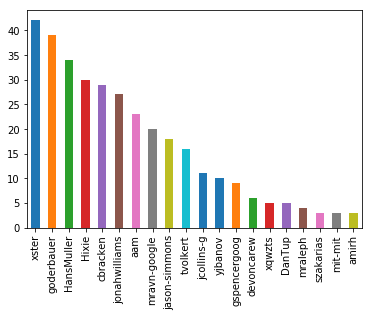

In [2091]:
actual = test_df['completed_by']
pd.value_counts(actual).plot.bar()

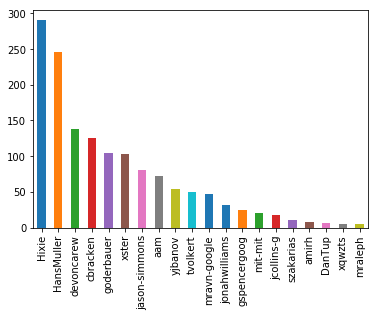

In [2092]:
pd.value_counts(df['completed_by']).plot.bar()

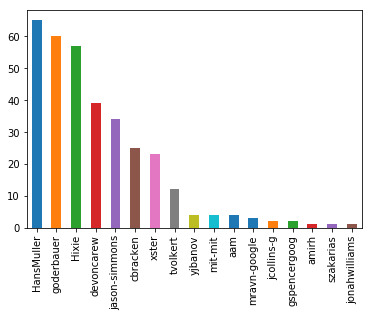

In [2093]:
pd.value_counts(preds).plot.bar()

In [2094]:
overall_counts = pd.value_counts(df['completed_by'])
# list of devs sorted in order of highest contribution
sorted_dev_list = overall_counts.index.values
pred_counts = pd.value_counts(preds)
actual_counts = pd.value_counts(actual)

percent_diff = {}
vals = []
counts = []
missing = set()
for dev in sorted_dev_list:
    if dev in pred_counts:
        val = 100 * (pred_counts[dev] - actual_counts[dev]) / (actual_counts[dev])
        percent_diff[dev] = val
        counts.append(overall_counts[dev])
        vals.append(val)
    else:
        missing.add(dev)
print("devs not included in predictions: ")
print(list(missing))

devs not included in predictions: 
['DanTup', 'mraleph', 'xqwzts']


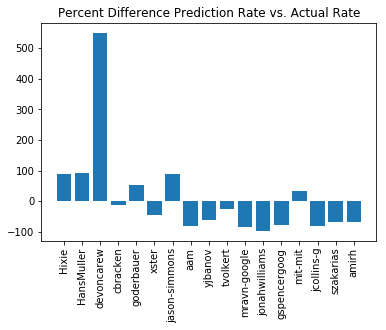

In [2095]:
plt.bar(percent_diff.keys(), percent_diff.values())
plt.title("Percent Difference Prediction Rate vs. Actual Rate")
plt.xticks(rotation=90)
plt.show()

R^2: 0.5148056315216505


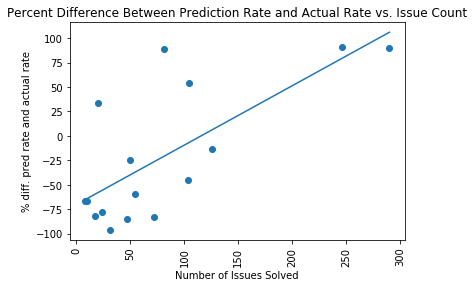

In [2096]:
# remove the outlier
del vals[2]
del counts[2]
# create best fit line
z = np.polyfit(x=counts, y=vals, deg=1)
p = np.poly1d(z)
trend_line = p(counts)
# test best fit
yhat = trend_line    
ybar = np.sum(vals)/len(vals)
ssreg = np.sum((yhat-ybar)**2) 
sstot = np.sum((vals - ybar)**2)
print("R^2: " + str(ssreg / sstot))
# create plots
plt.scatter(counts, vals)
plt.title("Percent Difference Between Prediction Rate and Actual Rate vs. Issue Count")
plt.xticks(rotation=90)
plt.xlabel("Number of Issues Solved")
plt.ylabel("% diff. pred rate and actual rate")
plt.plot(counts, trend_line)
plt.show()

In [2097]:
#TODO: look at assigning open issues and seeing what overspecialization problem would look like.

In [2098]:
test_df.head(5)

,body,closed_date,comments,completed_by,created_date,title,a: accessibility,a: animation,a: china,a: fidelity,...,4950,4951,4952,4953,4954,4955,4956,4957,4958,4959
1100,per recommend convent in object C program http...,2017-12-01 12:30:03,13,mravn-google,2017-05-13 20:56:17,renam objc plugin to have flt prefix,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1101,when we improv our color correct on older andr...,2017-12-04 20:03:43,2,jason-simmons,2017-08-02 22:36:05,consid faster mayb less accur way of handl col...,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1102,I have a hard time understand whi the api is n...,2017-12-04 21:43:10,1,Hixie,2017-11-30 21:26:32,scaffold key current state show bottom sheet q...,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1103,If you have two test in the same file the firs...,2017-12-05 03:49:15,0,yjbanov,2017-08-25 23:37:58,semant node id gener should be reset between test,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1104,We need a way for custom painter to provid add...,2017-12-05 03:49:15,3,yjbanov,2016-02-08 18:55:48,make custom paint access,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2099]:
test_df.tail(5)

,body,closed_date,comments,completed_by,created_date,title,a: accessibility,a: animation,a: china,a: fidelity,...,4950,4951,4952,4953,4954,4955,4956,4957,4958,4959
1432,flutter crash report pleas file at http github...,2018-05-24 20:42:47,7,devoncarew,2017-07-11 04:35:48,flutter tool should initi intl default local m...,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1433,I m pop up a simpl dialog with prompt text and...,2018-05-25 16:56:25,2,goderbauer,2018-05-22 12:10:45,android text entri field under talk back doe n...,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1434,,2018-05-25 23:20:08,2,cbracken,2018-05-10 02:14:44,local engin build on io are broken becaus of f...,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1435,In flutter exampl stock with an i pod touch co...,2018-05-25 23:42:39,6,aam,2016-08-08 22:13:50,flutter drive fail to detect io hardwar,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1436,turn talk back on and doubl tap on a checkbox ...,2018-05-26 01:42:03,10,jonahwilliams,2018-05-21 17:36:14,activ a switch or checkbox with talk back no l...,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
